# Download the reuters dataset

In [4]:
!wget -N https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.tar.gz
docs = !tar xvzf reuters21578.tar.gz

--2021-05-03 17:57:18--  https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.tar.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File 'reuters21578.tar.gz' not modified on server. Omitting download.



# Parsing the reuters dataset

In [2]:
from bs4 import BeautifulSoup

X_raw=[]
Y_raw=[]

for doc in docs:
    if doc.endswith(".sgm"):
        with open(doc[2:],"rb") as inp:# when I tried to get filenames,always start with "x ",so I have to exclude these two characters,otherwise I can not read the file
            data = inp.read()
            soup = BeautifulSoup(data,"html.parser")
            files = soup.findAll('reuters')
        for file in files:
            try:
                arti=file.find("body")
                X_raw.append(arti.text)#remove the last word reuter
            except:
                X_raw.append(None)
        for file in files:
            try:
                topi=file.find("topics")
                if topi.text =="":
                    Y_raw.append("0")
                elif len(topi.findChildren())>2:
                    t=[ele.text for ele in topi.findChildren()]
                    Y_raw.append(" ".join(t))
                else:
                    Y_raw.append(topi.text)
            except:
                Y_raw.append("0")

# Tokenize the dataset

In [21]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

def text_cleaning(text): # create a function to preprocess some special situations of data
    text = text.lower()
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'ve","have",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"n't","not",text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = text.strip()
    return text



news_dic={"Topic":Y_raw,"Content":X_raw}
df_reu = pd.DataFrame.from_dict(news_dic)
df_reu = df_reu[pd.notnull(df_reu["Content"])] # delete the data if there is body tag information
df_reu["Content"] = df_reu["Content"].map(lambda con : text_cleaning(con)) # using function to clean the data
df_reu["Content"] = df_reu["Content"].map(lambda con : tokenizer.tokenize(con)) #  tokenize the dataset
df_reu["Content"] = df_reu["Content"].map(lambda cons : [lemmatizer.lemmatize(con) for con in cons][:-1]) # lemmatize the word and remove the last word reuter
df_reu["Content"] = df_reu["Content"].map(lambda tokens: " ".join(tokens)) # join tokens to a string

Visualize data to check if the dataset is balanced

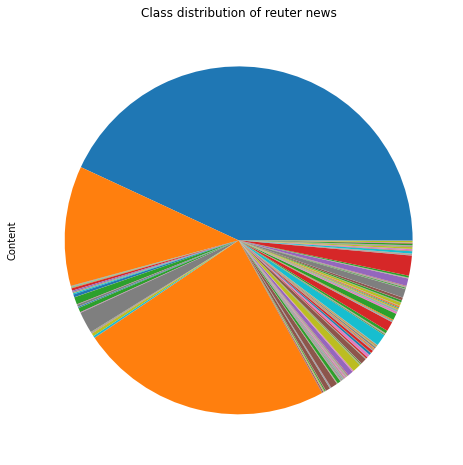

In [22]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,8), dpi= 72)
df_reu.groupby("Topic").Content.count().plot.pie(labels=None)
plt.title("Class distribution of reuter news")
plt.show()

Based on the pie chart above, we can infer that dataset we parsed is pretty inbalanced, so we need to resample the data,otherwise the recall for labels with small amounts of data may result in being too low if we use this dataset to train a model.To balance the dataset,we can adjust weight parameter in the classifier.

## Prepare the reuter traing and testing dataset

In [23]:
df_reu["Topic_split"]= df_reu["Topic"].map(lambda topic: topic.split()) # change topics to a list of multilabels

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

X,y=df_reu["Content"],df_reu["Topic_split"]

mlb = MultiLabelBinarizer()
mlb.fit(y)
y = mlb.transform(y)

X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8,test_size=0.2)

# Prepare the pipeline for Reuter with probabilistic classifier with RandomForestClassfier
Here I choose hashing and tfidf vectorizer to extract features and compare which one has better performance

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



tfidf_v=("tfidf", TfidfVectorizer(stop_words="english"))# removing meaningless stop words
hasing_v=("hashing",HashingVectorizer(stop_words="english"))# removing meaningless stop words

re_model=("powerset",LabelPowerset(RandomForestClassifier(class_weight="balanced",n_estimators=10)))# adjust weight to handle the unbalanced dataset


re_tfidf_pipe = Pipeline([tfidf_v, re_model])
re_hasing_pipe = Pipeline([hasing_v, re_model])


grid_tfidf_p = {"tfidf__ngram_range": [(1,1),(1,2)],
              "tfidf__smooth_idf" :[True, False]
             }

grid_hashing_p = {"hashing__ngram_range":[(1,1),(1,2)],
               "hashing__alternate_sign":[True,False]}


grid_tfidf = GridSearchCV(re_tfidf_pipe, param_grid=grid_tfidf_p,cv=5)
grid_tfidf.fit(X_train, y_train)

tfidf_best=grid_tfidf.best_score_
tfidf_best_para=grid_tfidf.best_params_

In [29]:
grid_hashing = GridSearchCV(re_hasing_pipe, param_grid=grid_hashing_p,cv=5)
grid_hashing.fit(X_train, y_train)

hashing_best=grid_hashing.best_score_
hashing_best_para=grid_hashing.best_params_

In [30]:
# Choose which vector has better performance
if hashing_best<tfidf_best:
    print(f"the best score:{round(tfidf_best,2)} is achieved by tfidf vector with parameters{tfidf_best_para}")
else:
    print(f"the best score:{round(hashing_best,2)} is achieved by hashing vector with parameters{hashing_best_para}")

the best score:0.7 is achieved by tfidf vector with parameters{'tfidf__ngram_range': (1, 1), 'tfidf__smooth_idf': True}


## Hyperparameters search for probabilistic classifier
Based on the result above, the tfidf vector has the best result.Now I will use tfidf best vector parameters to tune the model for best classifier parameters

In [31]:
tfidf_p_v=("tfidf", TfidfVectorizer(stop_words="english",ngram_range=(1,1),smooth_idf=True))
re_p_model=("powerset",LabelPowerset(classifier=RandomForestClassifier(class_weight="balanced",n_estimators=10)))
re_tfidf_p_pipe = Pipeline([tfidf_p_v, re_p_model])

grid_powerset_p={"powerset__classifier__criterion": ["gini", "entropy"],
              "powerset__classifier__min_samples_split" :[2,4]}

grid_p_powerset = GridSearchCV(re_tfidf_p_pipe, param_grid=grid_powerset_p,cv=5)
grid_p_powerset.fit(X_train,y_train)

powerset_best = grid_p_powerset.best_score_
powerset_best_para = grid_p_powerset.best_params_

print(f"the best score:{round(powerset_best,2)} is achieved by tfidf vector and RandomForest classifier with parameters{powerset_best_para}")

the best score:0.72 is achieved by tfidf vector and RandomForest classifier with parameters{'powerset__classifier__criterion': 'gini', 'powerset__classifier__min_samples_split': 4}


In [32]:
# Train the best probabilistic model
tfidf_p_v_best=("tfidf", TfidfVectorizer(stop_words="english",ngram_range=(1,1),smooth_idf=True))
re_p_model_best=("powerset",LabelPowerset(classifier=RandomForestClassifier(class_weight="balanced",n_estimators=10,criterion='gini',min_samples_split=4)))
re_tfidf_p_pipe_best = Pipeline([tfidf_p_v_best,re_p_model_best])
re_tfidf_p_pipe_best.fit(X_train,y_train)
prediction_p=re_tfidf_p_pipe_best.predict(X_test)
#Evaluation
from sklearn.metrics import accuracy_score, classification_report
t_p=accuracy_score(y_test, prediction_p)
print(f"the accuracy on test data is {t_p}")
print()
print(classification_report(y_test, prediction_p))

the accuracy on test data is 0.7328058429701765

              precision    recall  f1-score   support

           0       0.68      0.92      0.78       703
           1       0.73      0.48      0.58       187
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       1.00      0.25      0.40         4
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.75      1.0

/home/m20/hanzhe/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m20/hanzhe/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


we can see that the general accuracy is 73% on the test data which is not very bad. However I noticed that recalls for some labels are very low while for some are extremely high. Our dataset is still unbalanced although I add class_weight="balanced",so we need more methods to balance the data.

## Hyperparameter search and Prepare the pipeline for Reuter with non-probabilistic classifier with LinearSVC Classfier

In [34]:
# Explore the non-probabilistic classifer
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import numpy as np

tfidf_np_v=("tfidf", TfidfVectorizer(stop_words="english",ngram_range=(1,1),smooth_idf=True))
re_np_model=("svm",LinearSVC(class_weight="balanced",dual=True,max_iter=30000))
re_tfidf_np_pipe = Pipeline([tfidf_np_v, re_np_model])

grid_svm_np={"svm__intercept_scaling": [1, 2],
              "svm__multi_class" :["ovr","crammer_singer"]}

svm_np = GridSearchCV(re_tfidf_np_pipe, param_grid=grid_svm_np,cv=2)

X,y= df_reu['Content'],df_reu['Topic']

le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)


X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8,test_size=0.2,random_state=123)


svm_np.fit(X_train,y_train)

svm_best = svm_np.best_score_
power_set_para = svm_np.best_params_

print(f"the best score :{svm_best} is achieved by parameters {power_set_para}")

the best score :0.7453966414408806 is achieved by parameters {'svm__intercept_scaling': 2, 'svm__multi_class': 'ovr'}


In [38]:
# Train the best non-probabilistic model
tfidf_np_v_best=("tfidf", TfidfVectorizer(stop_words="english",ngram_range=(1,2),smooth_idf=True))
re_np_model_best=("svm",LinearSVC(class_weight="balanced",intercept_scaling=2,multi_class='ovr'))
re_tfidf_np_pipe_best = Pipeline([tfidf_np_v_best,re_np_model_best])
re_tfidf_np_pipe_best.fit(X_train,y_train)
prediction_np=re_tfidf_np_pipe_best.predict(X_test)
#Evaluation
from sklearn.metrics import accuracy_score, classification_report
t_np=accuracy_score(y_test, prediction_np)
print(f"the accuracy on test data is {t_np}")
print()
print(classification_report(y_test, prediction_np))

the accuracy on test data is 0.751065124771759

              precision    recall  f1-score   support

           0       0.96      0.69      0.80       697
           1       0.78      0.87      0.82       202
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.17      1.00      0.29         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          19       0.50      1.00      0.67         1
          20       1.00      1.00      1.00         8
          22       0.83      0.91

# Get 20 news rawdata

In [37]:
from sklearn.datasets import fetch_20newsgroups
X_raw_20, Y_raw_20= fetch_20newsgroups(subset="all",  remove=('headers', 'footers', 'quotes'), return_X_y=True,shuffle=True)

In [39]:
news_20_dic={"Topic_20":Y_raw_20,"Content_20":X_raw_20}#When I run all dataset,a memory error will be thrown, so I have to downsize the dataset
df_20 = pd.DataFrame.from_dict(news_20_dic)
df_20 = df_20[pd.notnull(df_20["Content_20"])] # delete the data if there is body tag information
df_20["Content_20"] = df_20["Content_20"].map(lambda con : text_cleaning(con)) # using function to clean the data
df_20["Content_20"] = df_20["Content_20"].map(lambda con : tokenizer.tokenize(con)) #  tokenize the dataset and remove the last word reuter
df_20["Content_20"] = df_20["Content_20"].map(lambda cons : [lemmatizer.lemmatize(con) for con in cons]) # lemmatize the word
df_20["Content_20"] = df_20["Content_20"].map(lambda tokens: " ".join(tokens)) # join tokens to a string

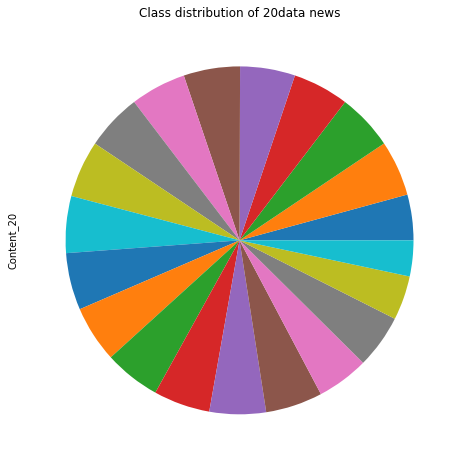

In [40]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,8), dpi= 72)
df_20.groupby("Topic_20").Content_20.count().plot.pie(labels=None)
plt.title("Class distribution of 20data news")
plt.show()

Based on the pie chart above, we can infer that the dataset is perfectly balanced,in this case,we don't need to address the data anymore,then we just applied the same pipeline we created for reuter to 20news dataset to compare the performance.

# Prepare the 20news traing and testing dataset

In [41]:
from sklearn.preprocessing import OneHotEncoder

X_20,y_20=df_20["Content_20"],df_20["Topic_20"]




y_20=np.array(y_20).reshape(-1,1)
mlb.fit(y_20)
y_20=mlb.transform(y_20)

X_train_20,X_test_20,y_train_20,y_test_20=train_test_split(X_20, y_20, train_size=0.8,test_size=0.2)


# Prepare the pipeline for 20news dataset with probabilistic classifier with RandomForestClassfier

In [42]:
# Train the best probabilistic model
tfidf_p_v_best_20=("tfidf", TfidfVectorizer(stop_words="english",ngram_range=(1,1),smooth_idf=True))
re_p_model_best_20=("powerset",LabelPowerset(classifier=RandomForestClassifier(n_estimators=10,criterion='gini',min_samples_split=4)))
re_tfidf_p_pipe_best_20 = Pipeline([tfidf_p_v_best_20,re_p_model_best_20])
re_tfidf_p_pipe_best_20.fit(X_train_20,y_train_20)
prediction_p_20=re_tfidf_p_pipe_best_20.predict(X_test_20)

#Evaluation
from sklearn.metrics import accuracy_score, classification_report
t_p_20=accuracy_score(y_test_20, prediction_p_20)
print(f"the accuracy on test data is {t_p_20}")
print()
print(classification_report(y_test_20, prediction_p_20))

the accuracy on test data is 0.587273530711445

              precision    recall  f1-score   support

           0       0.43      0.39      0.41        84
           1       0.56      0.46      0.51       121
           2       0.50      0.63      0.56       118
           3       0.44      0.49      0.46       105
           4       0.53      0.58      0.55       107
           5       0.71      0.65      0.68       136
           6       0.62      0.58      0.60       126
           7       0.33      0.67      0.45       106
           8       0.73      0.66      0.69       126
           9       0.69      0.63      0.66       132
          10       0.69      0.77      0.73       115
          11       0.82      0.73      0.77       126
          12       0.51      0.40      0.45       112
          13       0.72      0.67      0.70       118
          14       0.63      0.64      0.64       114
          15       0.54      0.71      0.62       108
          16       0.64      0.57

# Prepare the pipeline for 20news with non-probabilistic classifier with LinearSVC Classfier

In [43]:
# Train the best non-probabilistic model
X_20,y_20=df_20["Content_20"],df_20["Topic_20"]
X_train_20,X_test_20,y_train_20,y_test_20=train_test_split(X_20, y_20, train_size=0.8,test_size=0.2)
tfidf_np_v_best_20=("tfidf", TfidfVectorizer(stop_words="english",ngram_range=(1,1),smooth_idf=True))
re_np_model_best_20=("svm",LinearSVC(intercept_scaling=2,multi_class='ovr'))
re_tfidf_np_pipe_best_20 = Pipeline([tfidf_np_v_best_20,re_np_model_best_20])
re_tfidf_np_pipe_best_20.fit(X_train_20,y_train_20)
prediction_np_20=re_tfidf_np_pipe_best_20.predict(X_test_20)

#Evaluation
from sklearn.metrics import accuracy_score, classification_report
t_np_20=accuracy_score(y_test_20, prediction_np_20)
print(f"the accuracy on test data is {t_np_20}")
print()
print(classification_report(y_test_20, prediction_np_20))

the accuracy on test data is 0.7551922227132125

              precision    recall  f1-score   support

           0       0.74      0.66      0.70        94
           1       0.68      0.69      0.68       116
           2       0.67      0.71      0.69       126
           3       0.67      0.61      0.64       129
           4       0.75      0.69      0.72       134
           5       0.86      0.78      0.82       122
           6       0.76      0.78      0.77       116
           7       0.79      0.78      0.78       118
           8       0.74      0.82      0.78        97
           9       0.54      0.86      0.66       125
          10       0.90      0.81      0.85       132
          11       0.85      0.82      0.83       104
          12       0.78      0.76      0.77       130
          13       0.90      0.85      0.88       123
          14       0.79      0.79      0.79       107
          15       0.72      0.79      0.76       115
          16       0.86      0.8

## VG Part
I already done the Hyperparameters search above

## Visualization for Reuters data-Train/Test accuracy

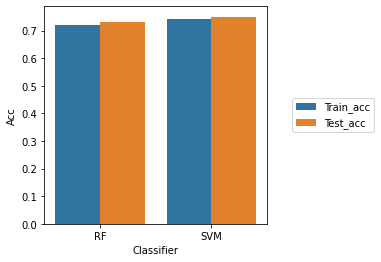

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
dict_r={"Classifier":["RF","RF","SVM","SVM"],"acc_type":["Train_acc","Test_acc","Train_acc","Test_acc"],"Acc":[0.72,0.73,0.74,0.75]}
df_r=pd.DataFrame.from_dict(dict_r)
plt.figure(figsize=(4,4))
sns.barplot(data=df_r,x="Classifier",y="Acc",hue="acc_type")
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5), ncol=1)

## 6 labels of highest F1 score

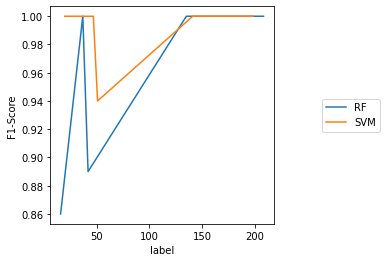

In [16]:
dict_r1={"label":[37,135,199,208,42,16,20,47,141,170,198,51],"Classifier":["RF"]*6+["SVM"]*6,"F1-Score":[1,1,1,1,0.89,0.86,1,1,1,1,1,0.94]}
df_r1=pd.DataFrame.from_dict(dict_r1)
plt.figure(figsize=(4,4))
sns.lineplot(data=df_r1,x="label",y="F1-Score",hue="Classifier")
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5), ncol=1)

## Visualization for 20news data.

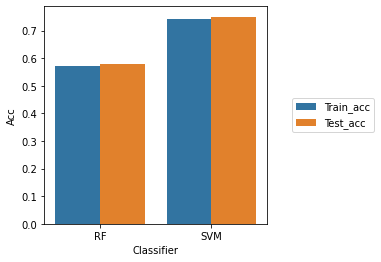

In [14]:
dict_20={"Classifier":["RF","RF","SVM","SVM"],"acc_type":["Train_acc","Test_acc","Train_acc","Test_acc"],"Acc":[0.57,0.58,0.74,0.75]}
df_20=pd.DataFrame.from_dict(dict_20)
plt.figure(figsize=(4,4))
sns.barplot(data=df_20,x="Classifier",y="Acc",hue="acc_type")
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5), ncol=1)

## 6 labels of highest F1 score

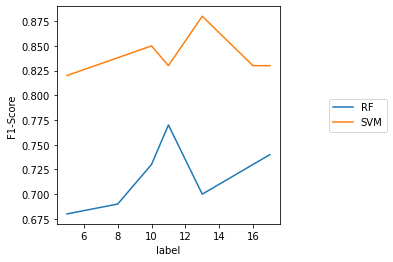

In [17]:
dict_20_2={"label":[11,17,10,13,8,5,13,10,11,16,17,5],"Classifier":["RF"]*6+["SVM"]*6,"F1-Score":[0.77,0.74,0.73,0.7,0.69,0.68,0.88,0.85,0.83,0.83,0.83,0.82]}
df_20_2=pd.DataFrame.from_dict(dict_20_2)
plt.figure(figsize=(4,4))
sns.lineplot(data=df_20_2,x="label",y="F1-Score",hue="Classifier")
plt.legend(loc='right', bbox_to_anchor=(1.5,0.5), ncol=1)

## Generalisability and  Statistically significant differences in performance

For Reuter data, both probabilistic and non-probabilistic classifiers outperformed a little in the test than in train data, which means my model is underfitting rather than overfitting, in this case, we need to make our model more complex and engage more balanced training data. Generally speaking, the probabilistic classifier is a little better than the non-probabilistic classifier. Furthermore, 6 labels of highest F1 scores vary largely. For 20 news data, both probabilistic and non-probabilistic classifiers outperformed a little in the test than in train data as well, however, the probabilistic classifier is much better than the non-probabilistic classifier, in this case, we need to adjust the model dramatically. Interestingly,4 of 6 labels of highest F1 scores are the same in both non-probabilistic and probabilistic classifiers, meaning that the 20news data is very balanced. Most importantly, at least for my model, probabilistic classifier owns stronger generalisability than non-probabilistic classifier

## Inductive biases for all parts of the pipelines and Overfitting
As I stated before, Reuter data are extremely unbalanced, thus the model we trained tends to be unbalanced as a result. In the pie chart, we can see that most data don't have a topic, so when we predict the test data, the recall for label 0 is highest among all labels. Also, I lemmatized the Reuter data at first, because I think this will make the model easier to predict, but this also means my model will learn fewer features, which may cause lower accuracy. Before I creating the model, I imported MultiLabelBinarizer to encode the label, I admit this is an efficient way to train, while it neglects the meaning of the word, in this case, it's also an inductive bias. When we choose the model, we more or less referred to the cheat sheet provided in the ppt, maybe this is also an inductive bias? Lastly, when I did the hyperparameter search, I always chose the hyperparameters leading to the highest accuracy in the training data, which seems logical. What if other hyperparameters may have lower training accuracy, but have higher test accuracy on the contrary.
Based on the plots above, my model seems to be a little underfitting，so I have to add more features and reduce the usage of the regularization. For overfitting issues, our data are too simple, so we need more various data. We can employ data augmentation methods to create more training data.